In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [2]:
data_url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"
df = pd.read_csv(data_url, header=None, compression='gzip')

In [3]:
column_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised",
    "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", "num_access_files",
    "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate",
    "label"
]

In [4]:
df.columns = column_names

In [5]:
df = df.drop(["protocol_type", "service", "flag", "label"], axis=1)
df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()

In [6]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(df)

In [7]:
#isolation forest
iso_forest = IsolationForest(contamination=0.01)
df['anomaly_iso'] = iso_forest.fit_predict(X)

In [10]:
#autocoder
input_dim = X.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
encoder = Dense(int(encoding_dim / 4), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='relu')(encoder)
decoder = Dense(encoding_dim, activation='relu')(decoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(X, X, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)



Epoch 1/50

1544/1544 [==============================] - 5s 2ms/step - loss: 0.7989 - val_loss: 0.7210
Epoch 2/50
1544/1544 [==============================] - 3s 2ms/step - loss: 0.7585 - val_loss: 0.7177
Epoch 3/50
1544/1544 [==============================] - 3s 2ms/step - loss: 0.7567 - val_loss: 0.7127
Epoch 4/50
1544/1544 [==============================] - 4s 2ms/step - loss: 0.7560 - val_loss: 0.7112
Epoch 5/50
1544/1544 [==============================] - 3s 2ms/step - loss: 0.7557 - val_loss: 0.7126
Epoch 6/50
1544/1544 [==============================] - 4s 3ms/step - loss: 0.7555 - val_loss: 0.7143
Epoch 7/50
1544/1544 [==============================] - 4s 2ms/step - loss: 0.7554 - val_loss: 0.7141
Epoch 8/50
1544/1544 [==============================] - 4s 2ms/step - loss: 0.7552 - val_loss: 0.7116
Epoch 9/50
1544/1544 [==============================] - 4s 2ms/step - loss: 0.7551 - val_loss: 0.7110
Epoch 10/50
1544/1544 [==============================] - 3s 2ms/step - loss: 0.

In [11]:
predictions = autoencoder.predict(X)
mse = np.mean(np.power(X - predictions, 2), axis=1)
df['mse'] = mse

15439/15439 [==============================] - 21s 1ms/step


In [12]:
threshold = np.percentile(mse, 95)
df['anomaly_ae'] = [1 if e > threshold else 0 for e in mse]

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


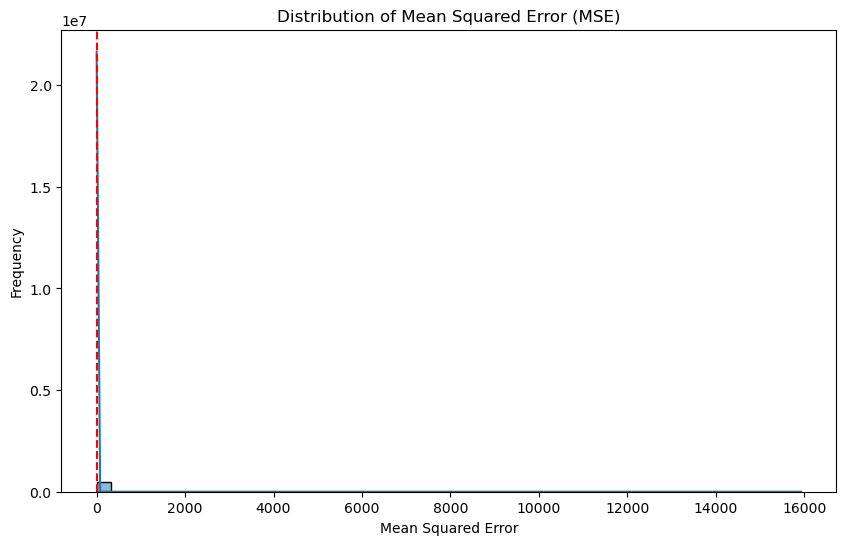

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(mse, bins=50, kde=True)
plt.axvline(threshold, color='r', linestyle='--')
plt.title('Distribution of Mean Squared Error (MSE)')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.show()

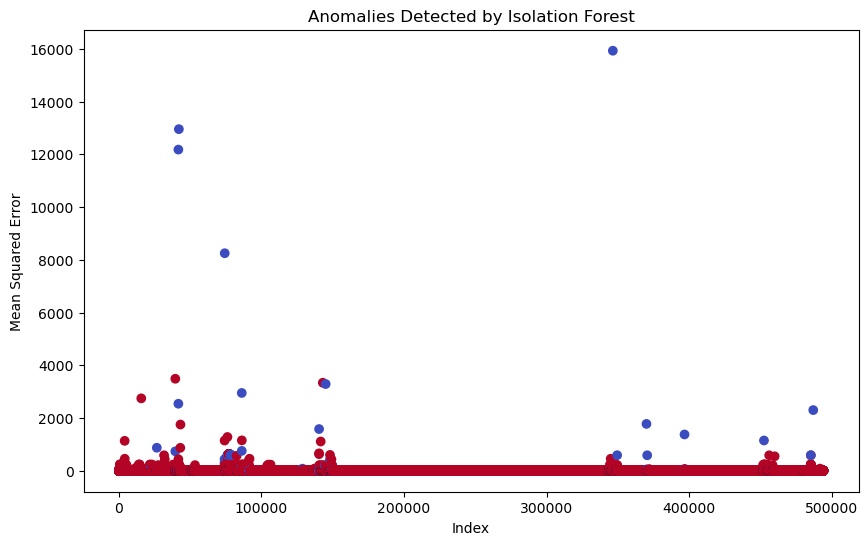

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['mse'], c=df['anomaly_iso'], cmap='coolwarm')
plt.title('Anomalies Detected by Isolation Forest')
plt.xlabel('Index')
plt.ylabel('Mean Squared Error')
plt.show()

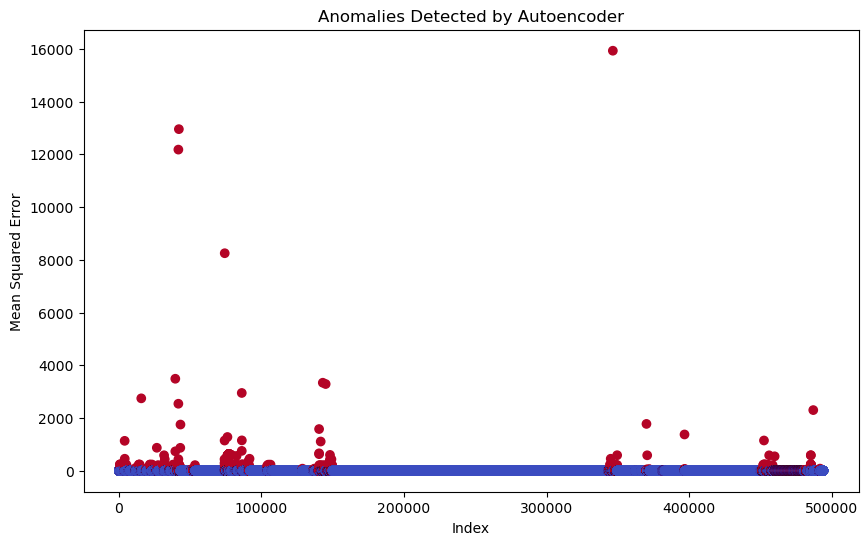

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['mse'], c=df['anomaly_ae'], cmap='coolwarm')
plt.title('Anomalies Detected by Autoencoder')
plt.xlabel('Index')
plt.ylabel('Mean Squared Error')
plt.show()

In [16]:
anomalies = df[(df['anomaly_iso'] == -1) | (df['anomaly_ae'] == 1)]
print(anomalies)

        duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
6              0        212       1940     0               0       0    0   
212            0        842        279     0               0       0    0   
219            0         31          0     0               0       0    0   
221            0          9         35     0               0       0    0   
227            0          9         37     0               0       0    0   
...          ...        ...        ...   ...             ...     ...  ...   
491804        35       1499       4152     0               0       0   12   
491808         1       1737        329     0               0       0    0   
491809        22        319       1054     0               0       0    6   
491917         0        225        779     0               0       0    0   
492755         0        205     288690     0               0       0    0   

        num_failed_logins  logged_in  num_compromised  ...  \
6            